In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Importing Data to Python Notebook**
## The data points are collected every 10 minutes using a microbit for approximately 21 days using various sensors(soil moisture, light, sound,heat) with microbit.
Below is the snippet to import the code, structure and display it.

In [ ]:
df= pd.read_csv("microbit (8).csv").drop(['Time (seconds)'],axis=1)
df.datetime = pd.to_datetime(df.datetime)
df = df.set_index("datetime").astype(float)
df.tail(10)

<ipython-input-2-e2c2899be1a5>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


,soil_moisture,light-level,temperature(C),sound-level
datetime,,,,
2025-03-13 16:56:00,26.400000,29.0,23.0,33.0
2025-03-13 17:06:00,28.133333,100.0,23.0,37.0
2025-03-13 17:16:00,25.333333,54.0,22.0,63.0
2025-03-13 17:26:00,26.933333,0.0,22.0,30.0
2025-03-13 17:36:00,26.666667,100.0,22.0,26.0
2025-03-13 17:46:00,27.600000,0.0,22.0,30.0
2025-03-13 17:56:00,26.400000,0.0,22.0,37.0
2025-03-13 18:06:00,27.866667,0.0,23.0,33.0
2025-03-13 18:16:00,24.400000,0.0,22.0,33.0


In [ ]:
print("First data collection: " + str(df.index[0]))
print("Last data collection: " + str(df.index[-1]))
print("Number of days the data has been collected:", (df.index[-1] - df.index[0]).days)

First data collection: 2025-02-25 17:36:00
Last data collection: 2025-03-13 18:26:00
Number of days the data has been collected: 16


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2310 entries, 2025-02-25 17:36:00 to 2025-03-13 18:26:00
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   soil_moisture   2310 non-null   float64
 1   light-level     2310 non-null   float64
 2   temperature(C)  2310 non-null   float64
 3   sound-level     2310 non-null   float64
dtypes: float64(4)
memory usage: 90.2 KB


# **Exploratory Data Analysis**

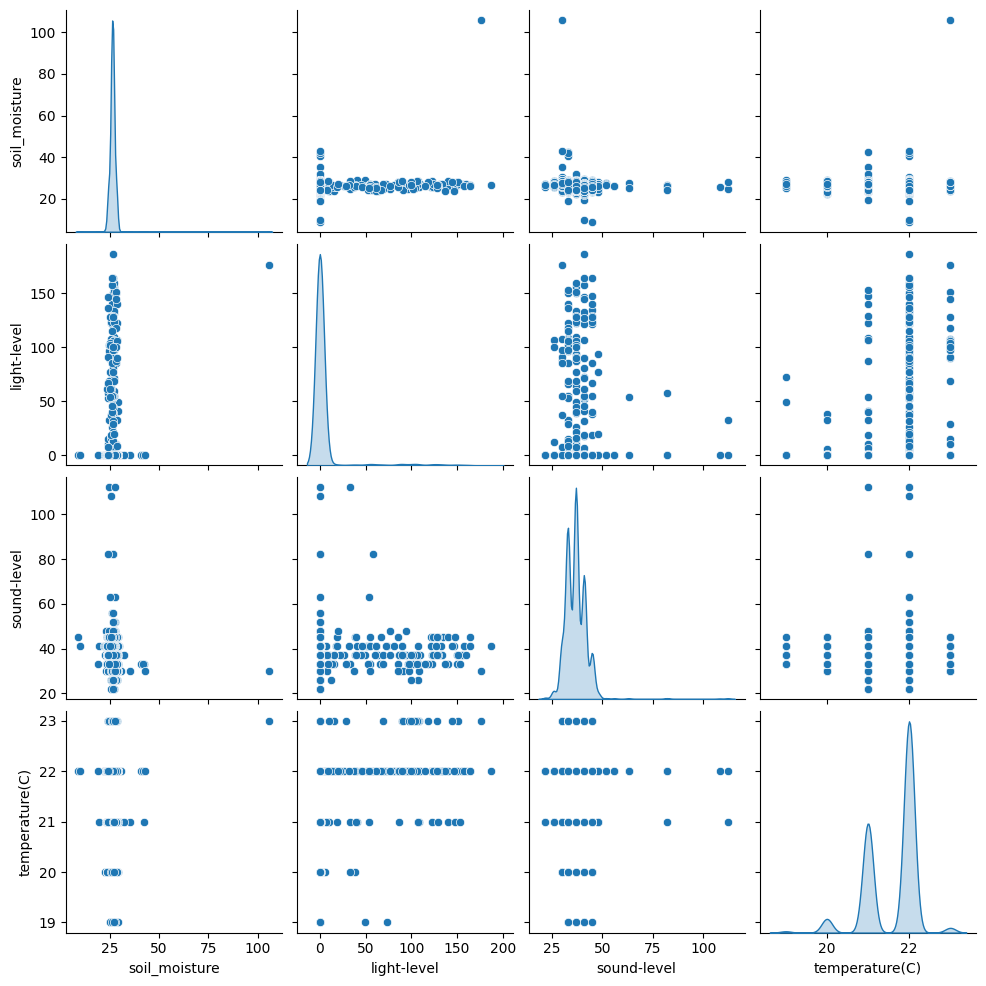

In [ ]:
# Use only the numeric columns
sns.pairplot(
    df[["soil_moisture", "light-level", "sound-level", "temperature(C)"]],
    diag_kind="kde"  # kernel density estimates on diagonals
)
plt.show()


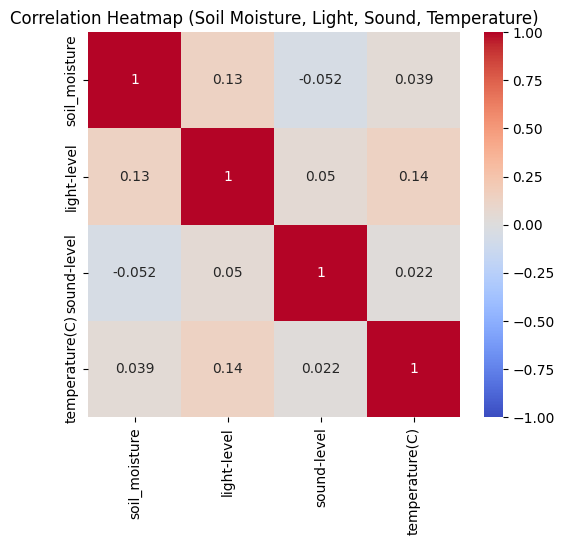

In [ ]:
corr = df[["soil_moisture", "light-level", "sound-level", "temperature(C)"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Soil Moisture, Light, Sound, Temperature)")
plt.show()


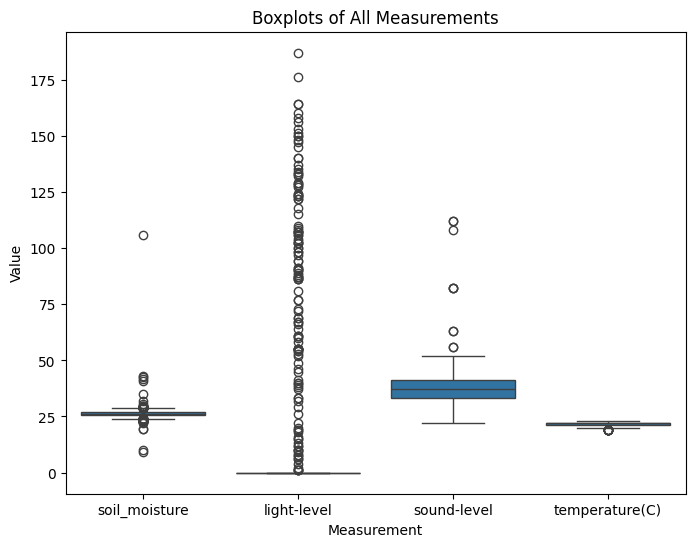

In [ ]:
# Transform data into a "long" format for easier plotting
long_df = df.melt(
    value_vars=["soil_moisture", "light-level", "sound-level", "temperature(C)"],
    var_name="Measurement",
    value_name="Value"
)

plt.figure(figsize=(8, 6))
sns.boxplot(data=long_df, x="Measurement", y="Value")
plt.title("Boxplots of All Measurements")
plt.show()


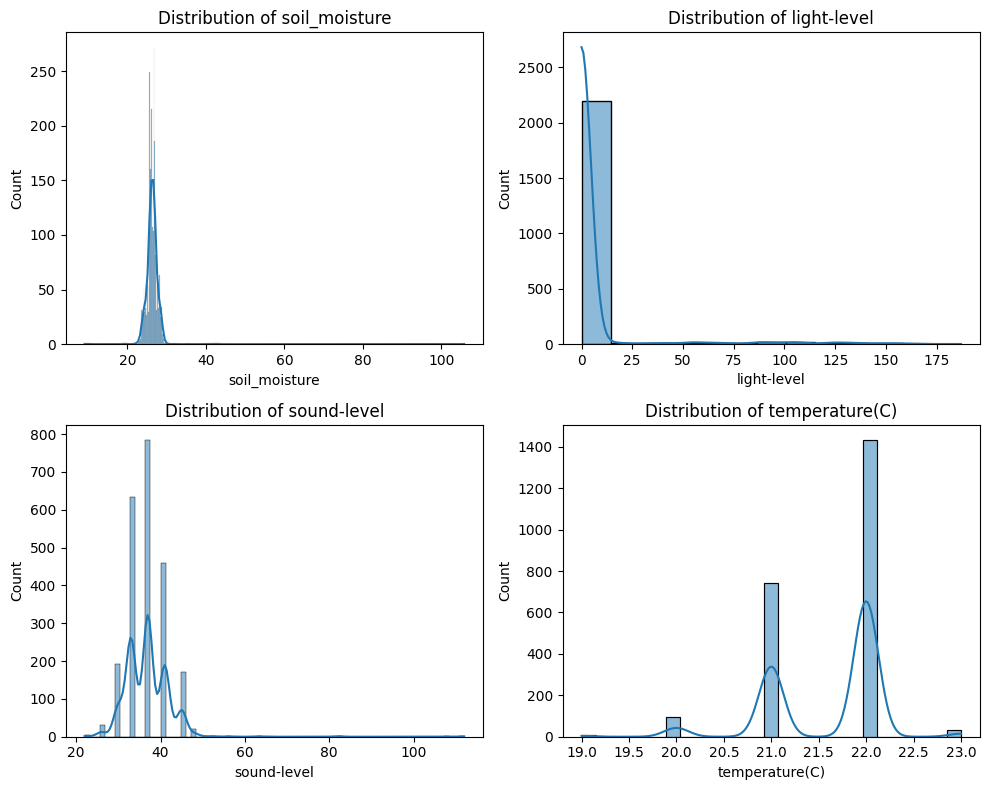

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2D array of Axes to iterate easily

columns = ["soil_moisture", "light-level", "sound-level", "temperature(C)"]

for ax, col in zip(axes, columns):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


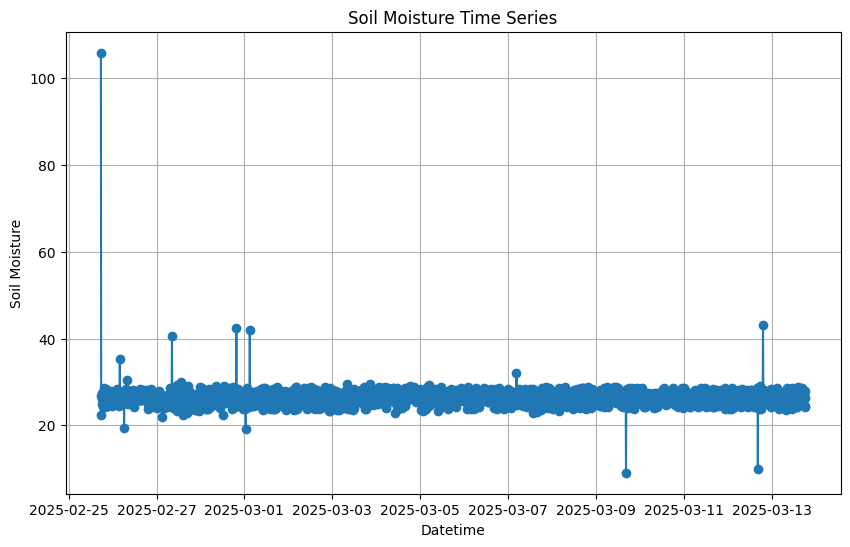

In [ ]:
# Plot the soil moisture time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['soil_moisture'], marker='o', linestyle='-')
plt.title('Soil Moisture Time Series')
plt.xlabel('Datetime')
plt.ylabel('Soil Moisture')
plt.grid(True)
plt.show()

# **Training the AI Forecasting Model**

Training set: 1845 rows, Test set: 462 rows
Test RMSE: 1.6679


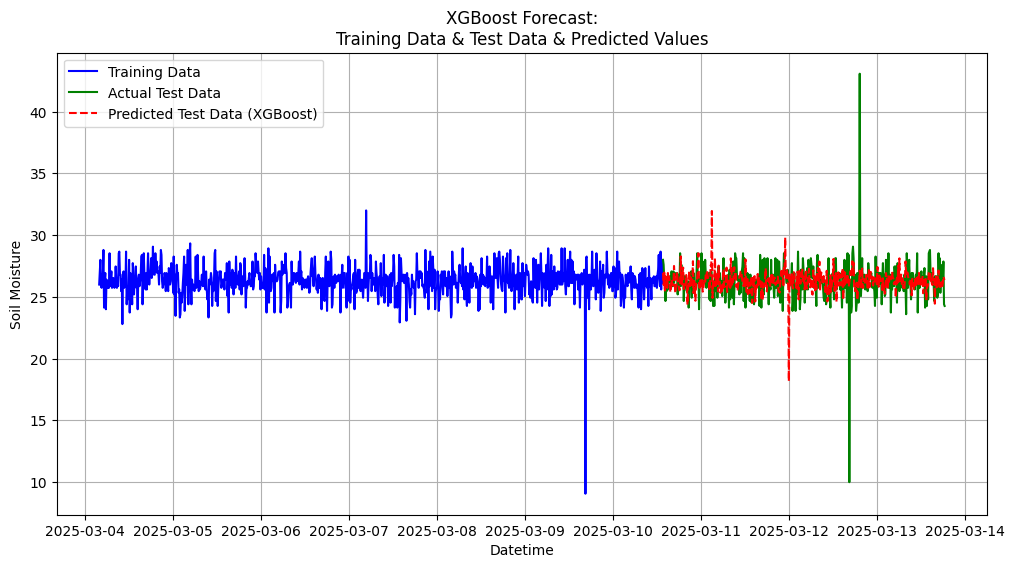

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Function to create lag features for the time series
def create_lag_features(data, n_lags=3):
    df_lag = data.copy()
    for lag in range(1, n_lags + 1):
        df_lag[f'lag_{lag}'] = df_lag['soil_moisture'].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag

# Create lag features (using 3 lags as an example)
n_lags = 3
df_lagged = create_lag_features(df, n_lags)

# Split the data: first 80% as training, last 20% as test
split_idx = int(len(df_lagged) * 0.8)
train_data = df_lagged.iloc[:split_idx]
test_data = df_lagged.iloc[split_idx:]
print(f"Training set: {len(train_data)} rows, Test set: {len(test_data)} rows")

# Define features (lag columns) and target variable
feature_cols = [f'lag_{lag}' for lag in range(1, n_lags + 1)]
X_train = train_data[feature_cols]
y_train = train_data['soil_moisture']
X_test = test_data[feature_cols]
y_test = test_data['soil_moisture']

# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: {:.4f}".format(rmse))

# For plotting, show only the last 50% of the training data
train_last_half = train_data.iloc[int(len(train_data) * 0.5):]

# Plotting the results
plt.figure(figsize=(12, 6))
# Plot the last 50% of training data (actual values)
plt.plot(train_last_half.index, train_last_half['soil_moisture'], label='Training Data', color='blue')
# Plot the actual test data
plt.plot(test_data.index, test_data['soil_moisture'], label='Actual Test Data', color='green')
# Plot the predicted test data
plt.plot(test_data.index, y_pred, label='Predicted Test Data (XGBoost)', color='red', linestyle='--')
plt.title("XGBoost Forecast:\nTraining Data & Test Data & Predicted Values")
plt.xlabel("Datetime")
plt.ylabel("Soil Moisture")
plt.legend()
plt.grid(True)
plt.show()